<a href="https://colab.research.google.com/github/zqiaohe/smi_tags/blob/main/news_sentiment_lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BASELINE

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import json

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
with open('/content/drive/MyDrive/FH_data/sentiment-analysis-in-russian/train.json') as f:
    raw_train = json.load(f)
with open('/content/drive/MyDrive/FH_data/sentiment-analysis-in-russian/test.json') as f:
    raw_test = json.load(f)

In [5]:
def ru_token(string):
    """russian tokenize based on nltk.word_tokenize. only russian letter remaind."""
    return [i for i in word_tokenize(string) if re.match(r'[\u0400-\u04ffа́]+$', i)]

In [6]:
params = {}
params['tokenizer'] = ru_token
params['stop_words'] = stopwords.words('russian')
params['ngram_range'] = (1, 3)
params['min_df'] = 3

In [7]:
tfidf  = TfidfVectorizer(**params)

In [8]:
tfidf.fit([i['text'] for i in raw_train + raw_test])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=3, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
                            'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
                            'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
                            'по', 'только', 'ее', 'мне', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function ru_token at 0x7f584d4fa440>, use_idf=True,
                vocabulary=None)

In [9]:
train = {}
val = {}
tmp = defaultdict(list)
for e in raw_train:
    tmp[e['sentiment']].append(e['text'])
for l in tmp:
    train[l], val[l] = train_test_split(tmp[l], test_size=0.2, random_state=2018)

In [10]:
def upsampling_align(some_dict, random_state=2018):
    rand = np.random.RandomState(random_state)
    upper = max([len(some_dict[l]) for l in some_dict])
    print('upper bound: {}'.format(upper))
    tmp = {}
    for l in some_dict:
        if len(some_dict[l]) < upper:
            repeat_time = int(upper/len(some_dict[l]))
            remainder = upper % len(some_dict[l])
            _tmp = some_dict[l].copy()
            rand.shuffle(_tmp)
            tmp[l] = some_dict[l] * repeat_time + _tmp[:remainder]
            rand.shuffle(tmp[l])
        else:
            tmp[l] = some_dict[l]
    return tmp

In [11]:
btrain = upsampling_align(train)

upper bound: 3227


In [12]:
m_params = {}
m_params['solver'] = 'lbfgs'
m_params['multi_class'] = 'multinomial'

In [13]:
softmax = LogisticRegression(**m_params)

In [14]:
train_x = [j for i in sorted(btrain.keys()) for j in btrain[i]]
train_y = [i for i in sorted(btrain.keys()) for j in btrain[i]]
softmax.fit(tfidf.transform(train_x), train_y)

KeyboardInterrupt: ignored

In [ ]:
test_x = [j for i in sorted(val.keys()) for j in val[i]]
true = [i for i in sorted(val.keys()) for j in val[i]]

In [ ]:
pred = softmax.predict(tfidf.transform(test_x))

In [ ]:
lab = LabelEncoder()
c_true = lab.fit_transform(true)
c_pred = lab.transform(pred)
print(classification_report(c_true, c_pred, target_names=lab.classes_, digits=5))

In [ ]:
bval = upsampling_align(val)

In [ ]:
b_test_x = [j for i in sorted(bval.keys()) for j in bval[i]]
b_true = [i for i in sorted(bval.keys()) for j in bval[i]]
b_pred = softmax.predict(tfidf.transform(b_test_x))
lab = LabelEncoder()
c_true = lab.fit_transform(b_true)
c_pred = lab.transform(b_pred)
print(classification_report(c_true, c_pred, target_names=lab.classes_, digits=5))

In [ ]:
sub_pred = softmax.predict(tfidf.transform([i['text'] for i in raw_test]))
sub_df = pd.DataFrame()
sub_df['id'] =  [i['id'] for i in raw_test]
sub_df['sentiment'] = sub_pred

In [ ]:
sub_df.to_csv('softmax_reg.csv', index=False)

#МОЯ ВЕРСИЯ

##Обработка данных — преобразование в нижний регистр

In [1]:
df = pd.read_json('/content/drive/MyDrive/FH_data/sentiment-analysis-in-russian/train.json')

NameError: ignored

In [140]:
df['text_lower'] = [x.lower() for x in df['text']]

In [ ]:
testdf = pd.read_json('/content/drive/MyDrive/FH_data/sentiment-analysis-in-russian/train.json')

In [ ]:
header = ['id', 'pubdate', 'pubtime', 'title', 'tag', 'theme', 'null']
baikaldf = pd.read_csv('/content/drive/MyDrive/FH_data/baikaldaily_all_sorted.csv', sep =';', error_bad_lines=False, names=header) 
baikaldf = baikaldf.drop(columns=['null'])
baikaldf = baikaldf[baikaldf['pubdate']!='None']

##Обработка данных — удаление знаков препинания и токенизация

In [141]:
from string import punctuation

In [142]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [143]:
punctuation = punctuation + '\n' + '»' + '«'

In [144]:
for i in range(len(df['text_lower'])):
  df['text_lower'][i] =  ''.join([c for c in df['text_lower'][i] if c not in punctuation]).split(' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [145]:
 df['text_lower']

0       [досудебное, расследование, по, факту, покупки...
1       [медики, рассказали, о, состоянии, пострадавше...
2       [прошел, почти, год, как, железнодорожным, опе...
3       [по, итогам, 12, месяцев, 2016, года, на, терр...
4       [астана, 21, ноября, kazakhstan, today, , аген...
                              ...                        
8258    [как, мы, писали, еще, весной, для, увеличения...
8259    [но, молодой, министр, национальной, экономики...
8260    [, в, енпф, назначен, новый, председатель, пра...
8261    [в, алматы, у, отделения, банка, произошло, на...
8262    [нпп, рк, атамекен, предлагает, создать, нацио...
Name: text_lower, Length: 8263, dtype: object

##Токенизация — Создание словаря сопоставления Vocab to Int

In [146]:
from collections import Counter

In [147]:
all_texts = []
for i in range(len(df['text_lower'])):
  all_texts.append(' '.join(df['text_lower'][i]))
all_texts = ' '.join(all_texts)

In [148]:
words = all_texts.split(' ')

In [149]:
count_words = Counter(words)
total_words = len(words)
sorted_words = count_words.most_common(total_words)

In [150]:
vocab_to_int = {w:i for i, (w,c) in enumerate(sorted_words)}

In [151]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

In [152]:
vocab_to_int

{'в': 1,
 'и': 2,
 '': 3,
 'на': 4,
 'по': 5,
 'с': 6,
 'что': 7,
 'не': 8,
 'года': 9,
 'для': 10,
 'за': 11,
 'к': 12,
 '–': 13,
 'а': 14,
 'из': 15,
 '—': 16,
 'тенге': 17,
 'о': 18,
 'это': 19,
 'как': 20,
 'до': 21,
 'от': 22,
 'году': 23,
 'также': 24,
 'казахстана': 25,
 'мы': 26,
 'ао': 27,
 'казахстан': 28,
 '2016': 29,
 'будет': 30,
 'рк': 31,
 'при': 32,
 'но': 33,
 'области': 34,
 'все': 35,
 'его': 36,
 'республики': 37,
 'млрд': 38,
 'этом': 39,
 'у': 40,
 '1': 41,
 'он': 42,
 'то': 43,
 'более': 44,
 'развития': 45,
 'лет': 46,
 'их': 47,
 'или': 48,
 'так': 49,
 'было': 50,
 'уже': 51,
 'том': 52,
 'время': 53,
 'которые': 54,
 'был': 55,
 'только': 56,
 'есть': 57,
 'же': 58,
 'будут': 59,
 '2015': 60,
 'алматы': 61,
 'казахстане': 62,
 'год': 63,
 'я': 64,
 'тоо': 65,
 'млн': 66,
 'страны': 67,
 'компании': 68,
 'банка': 69,
 'были': 70,
 'со': 71,
 'того': 72,
 'экономики': 73,
 'является': 74,
 'рамках': 75,
 'об': 76,
 'енпф': 77,
 'если': 78,
 'назад': 79,
 '2017'

In [153]:
 df['encode'] =  df['text_lower']

##Токенизация — кодирование слов

In [157]:
for i in range(len(df['text_lower'])):
  df['encode'][i] = [vocab_to_int[w] for w in df['text_lower'][i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [158]:
df['encode']

0       [1868, 963, 5, 1155, 2270, 77, 4797, 985, 65, ...
1       [11461, 1672, 18, 1614, 16113, 6811, 4, 350, 5...
2       [1530, 393, 63, 20, 5509, 22939, 17106, 25276,...
3       [5, 174, 221, 233, 29, 9, 4, 271, 37, 5565, 74...
4       [107, 352, 190, 650, 1553, 3, 704, 31, 5, 779,...
                              ...                        
8258    [20, 26, 7461, 82, 5551, 10, 1387, 1729, 14, 2...
8259    [33, 2728, 198, 99, 73, 438, 4729, 25239, 512,...
8260    [3, 1, 77, 540, 313, 151, 138, 3, 10603, 876, ...
8261    [1, 61, 40, 1561, 69, 1004, 7759, 71, 189950, ...
8262    [761, 31, 816, 1800, 526, 303, 5872, 306, 10, ...
Name: encode, Length: 8263, dtype: object

##Кодирование меток

In [159]:
df

,text,id,sentiment,text_lower,encode
0,Досудебное расследование по факту покупки ЕНПФ...,1945,negative,"[досудебное, расследование, по, факту, покупки...","[1868, 963, 5, 1155, 2270, 77, 4797, 985, 65, ..."
1,Медики рассказали о состоянии пострадавшего му...,1957,negative,"[медики, рассказали, о, состоянии, пострадавше...","[11461, 1672, 18, 1614, 16113, 6811, 4, 350, 5..."
2,"Прошел почти год, как железнодорожным оператор...",1969,negative,"[прошел, почти, год, как, железнодорожным, опе...","[1530, 393, 63, 20, 5509, 22939, 17106, 25276,..."
3,По итогам 12 месяцев 2016 года на территории р...,1973,negative,"[по, итогам, 12, месяцев, 2016, года, на, терр...","[5, 174, 221, 233, 29, 9, 4, 271, 37, 5565, 74..."
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,1975,negative,"[астана, 21, ноября, kazakhstan, today, , аген...","[107, 352, 190, 650, 1553, 3, 704, 31, 5, 779,..."
...,...,...,...,...,...
8258,"Как мы писали еще весной, для увеличения сбыта...",10312,positive,"[как, мы, писали, еще, весной, для, увеличения...","[20, 26, 7461, 82, 5551, 10, 1387, 1729, 14, 2..."
8259,Но молодой министр национальной экономики Биши...,10313,negative,"[но, молодой, министр, национальной, экономики...","[33, 2728, 198, 99, 73, 438, 4729, 25239, 512,..."
8260,\n \nВ ЕНПФ назначен новый председатель правле...,10314,neutral,"[, в, енпф, назначен, новый, председатель, пра...","[3, 1, 77, 540, 313, 151, 138, 3, 10603, 876, ..."
8261,В Алматы у отделения банка произошло нападение...,10315,negative,"[в, алматы, у, отделения, банка, произошло, на...","[1, 61, 40, 1561, 69, 1004, 7759, 71, 189950, ..."


##Заполнение и усечение новостей

In [161]:
df['sentiment'].unique()

array(['negative', 'positive', 'neutral'], dtype=object)

In [162]:
df['label'] = df['sentiment']

In [164]:
for i in range(len(df['sentiment'])):
  if df['sentiment'][i] == 'negative':
    df['label'][i] = -1
  elif df['sentiment'][i] == 'neutral':
    df['label'][i] = 0
  else:
    df['label'][i] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [171]:
df.groupby('sentiment').count()

,text,id,text_lower,encode,label
sentiment,,,,,
negative,1434,1434,1434,1434,1434
neutral,4034,4034,4034,4034,4034
positive,2795,2795,2795,2795,2795


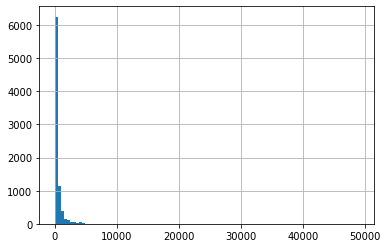

count     8263.000000
mean       515.478519
std       1192.447019
min          4.000000
25%        165.000000
50%        273.000000
75%        484.000000
max      49039.000000
dtype: float64

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
news_len = [len(x) for x in df['encode']]
pd.Series(news_len).hist(bins=100)
plt.show()
pd.Series(news_len).describe()

In [183]:
df['encode']

0       [1868, 963, 5, 1155, 2270, 77, 4797, 985, 65, ...
1       [11461, 1672, 18, 1614, 16113, 6811, 4, 350, 5...
2       [1530, 393, 63, 20, 5509, 22939, 17106, 25276,...
3       [5, 174, 221, 233, 29, 9, 4, 271, 37, 5565, 74...
4       [107, 352, 190, 650, 1553, 3, 704, 31, 5, 779,...
                              ...                        
8258    [20, 26, 7461, 82, 5551, 10, 1387, 1729, 14, 2...
8259    [33, 2728, 198, 99, 73, 438, 4729, 25239, 512,...
8260    [3, 1, 77, 540, 313, 151, 138, 3, 10603, 876, ...
8261    [1, 61, 40, 1561, 69, 1004, 7759, 71, 189950, ...
8262    [761, 31, 816, 1800, 526, 303, 5872, 306, 10, ...
Name: encode, Length: 8263, dtype: object

In [207]:
seq_length = 515

In [196]:
features = np.zeros((len(df['encode']), seq_length), dtype = int)
for i, news in enumerate(df['encode']):
  news_len = len(news)
  if news_len < 1707:
    zeroes = list(np.zeros(seq_length-news_len))
    new = zeroes+news
  elif news_len > seq_length:
    new = review[0:seq_length]      
  features[i,:] = np.array(new)



In [208]:
def pad_features(pdseries, seq_length):
  features = np.zeros((len(df['encode']), seq_length), dtype = int)
  for i, news in enumerate(df['encode']):
    news_len = len(news)
    if news_len < seq_length:
      zeroes = list(np.zeros(seq_length-news_len))
      new = zeroes+news
    elif news_len > seq_length:
      new = news[0:seq_length]      
    features[i,:] = np.array(new)
  return features

In [220]:
import numpy as np

In [211]:
features = pad_features(df['encode'], seq_length)
len_feat = len(features)

In [223]:
label = df['label'].to_numpy()

In [225]:
type(label)

numpy.ndarray

In [226]:
split_frac = 0.8
train_x = features[0:int(split_frac*len_feat)]
train_y = label[0:int(split_frac*len_feat)]
remaining_x = features[int(split_frac*len_feat):]
remaining_y = label[int(split_frac*len_feat):]
valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]

In [227]:
import torch
from torch.utils.data import DataLoader, TensorDataset
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
# dataloaders
batch_size = 50
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [228]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 515])
Sample input: 
 tensor([[    0,     0,     0,  ...,     6,  2724,   660],
        [    0,     0,     0,  ...,     3,   620, 88564],
        [    0,     0,     0,  ...,  1880,   620,  1275],
        ...,
        [    0,     0,     0,  ...,   459,   353,  1324],
        [42036,   620, 23380,  ...,     7,    10,  2045],
        [    0,     0,     0,  ...,     3,     3,     3]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([-1,  1,  0, -1,  0,  1,  1, -1,  0,  0,  1,  1,  0,  1, -1,  0, -1,  0,
         0,  0,  1,  1, -1,  0,  1,  1,  0,  0, -1,  0,  0,  0, -1,  0,  0,  1,
         0,  0, -1,  1,  0, -1,  0, -1,  0,  0,  0,  0, -1,  1])


In [229]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

In [231]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentLSTM(
  (embedding): Embedding(189952, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [235]:
train_on_gpu = True


In [236]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


# training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.LongTensor)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

RuntimeError: ignored